Dr Oliviero Andreussi, olivieroandreuss@boisestate.edu

Boise State University, Department of Chemistry and Biochemistry

# Fitting and Data Analysis for the UV-Vis Particle in a Box Experiment {-}

Before we start, let us import the main modules that we will need for this lecture. You may see some new modules in the list below, we will add more details in the right sections.

In [1]:
# @title Notebook Setup { display-mode: "form" }
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
# The following needs to be the path of the folder with all your datafile in .csv format
base_path = '/Users/School/PycharmProjects/PChemLab/ParticleBox_Data/PIB/'

In [2]:
# @title Functions to load the data { display-mode: "form" }
def load_data_to_file_dict(file_dict):
    """
    Load a uv-vis .csv file.
    The format of the file should have two rows of headers and two columns of data (time and absorbance)
    The file may have additional information from the instrument saved at the bottom

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded

    Action:
        Add to file_dict a Pandas DataFrame with two columns: time (in seconds) and absorbance (in input units)
    """
    data = pd.read_csv(file_dict['path']+file_dict['name'],header=1,usecols=(0,1)).apply(pd.to_numeric,errors='coerce').dropna()
    data['Abs'] = data['Abs']-data['Abs'].min() # forces the data to be above zero
    if data.keys()[0] == 'Time (sec)' :
        data = data.rename(columns={'Time (sec)':'time'})
        file_dict['xaxis']='time'
    elif data.keys()[0] == 'Time (min)' :
        data['time'] = data['Time (min)'] * 60
        data = data.drop('Time (min)',axis=1)
        file_dict['xaxis']='time'
    elif data.keys()[0] == 'Wavelength (nm)' :
        data = data.rename(columns={'Wavelength (nm)':'wavelength'})
        file_dict['xaxis']='wavelength'
    data = data.rename(columns={'Abs':'absorbance'})
    file_dict['data'] = data
    return

def load_data_to_file_list(file_list):
    """
    Given a list of dictionary files, recursively use load_data_to_file_dict to load the data into each of the dictionaries

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded

    Action:
        Add to each file_dict a Pandas DataFrame with two columns: time (in seconds) and temperature (in input units)
    """
    for f in file_list :
        if not ('data' in f): load_data_to_file_dict(f)
    return

def plot_file_dict(file_dict, semilog=False, with_fit=False):
    """
    Given a dictionary file of a bomb calorimetry experiment, plot temperature vs. time.

    Input variables:
        file_dict : a dictionary file with 'path' and 'name' keys corresponding to the file to be loaded
        semilog : use a logarithmic scale for the absorbance axis
        with_fit : plot the fitted curve, if present

    Action:
        Plot absorbance vs. time for the selected file
    """
    fig, ax = plt.subplots()
    if not ('data' in file_dict):
        load_data_to_file_dict(f)
    xaxis = file_dict['xaxis']
    if semilog :
        plt.semilogy(file_dict['data'][xaxis],file_dict['data']['absorbance'],label=file_dict['label'])
        if with_fit and 'absorbance_fitted' in file_dict['data'].keys():
            plt.semilogy(file_dict['data'][xaxis],file_dict['data']['absorbance_fitted'],':',label=file_dict['label']+' fit')
    else:
        plt.plot(file_dict['data'][xaxis],file_dict['data']['absorbance'],label=file_dict['label'])
        if with_fit and 'absorbance_fitted' in file_dict['data'].keys():
            plt.plot(file_dict['data'][xaxis],file_dict['data']['absorbance_fitted'],':',label=file_dict['label']+' fit')
    if xaxis == 'time' :
        plt.xlabel('Time (s)')
    elif xaxis == 'wavelength' :
        plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance (a.u.)')
    plt.legend()
    plt.show()

def plot_file_list(file_list,key='',value=[''],semilog=False,with_fit=False):
    """
    Given a list of dictionary files, plot absorbance vs. time for each file into the same plot.
    If key/value are specified, only plot the files for which the key has the specified value.

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
        key: a string with the name of the key to shortlist the files
        value: the value of the key used to select the shortlist of files

    Action:
        Plot absorbance vs. time for the selected files
    """
    if value == '' or key == '':
        file_shortlist = file_list
    else :
        file_shortlist = [f for f in file_list if f[key] in value ]
    fig, ax = plt.subplots()
    for i,f in enumerate(file_shortlist) :
        color='C'+str(i)
        if not ('data' in f):
            load_data_to_file_dict(f)
        xaxis = f['xaxis']
        if semilog :
            plt.semilogy(f['data'][xaxis],f['data']['absorbance'],color=color,label=f['label'])
            if with_fit and 'absorbance_fitted' in f['data'].keys():
                plt.semilogy(f['data'][xaxis],f['data']['absorbance_fitted'],':',color=color,label=f['label']+' fit')
        else:
            plt.plot(f['data'][xaxis],f['data']['absorbance'],color=color,label=f['label'])
            if with_fit and 'absorbance_fitted' in f['data'].keys():
                plt.plot(f['data'][xaxis],f['data']['absorbance_fitted'],':',color=color,label=f['label']+' fit')
    if xaxis == 'time' :
        plt.xlabel('Time (s)')
    elif xaxis == 'wavelength' :
        plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance (a.u.)')
    plt.legend()
    plt.show()

Set the local path, in case you have absorption spectra that you want to plot

In [3]:
# @title Set Local Path { display-mode: "form" }
# The following needs to be the path of the folder with all your collected data in .csv format
 # @param {type:"string"}
path = '/Users/School/PycharmProjects/PChemLab/ParticleBox_Data/PIB/'

## Visualize the Systems {-}

The following module needs to be installed on Colab. We won't need it too much for this analysis, but they offer a lot of nice features for chemistry programming. 

In [4]:
# @title Install and load RDKit { display-mode: "form" }
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
!pip install cirpy
import cirpy

In particular we can use them to draw the molecules in our experiments. Here are the CAS numbers (note that for one of the molecules CirPy is not able to find the SMILES and you will need to pass it directly):
* 977-96-8
* 605-91-4
* 4727-49-5
* 14187-31-6
* 4727-50-8
* 18300-31-7 ('[I-].CCN1C=C\C(=C/C=C/C=C/c2cc\[n+\](CC)c3ccccc23)c4ccccc14')
* 2197-01-5
* 905-97-5
* 514-73-8
* 3071-70-3
* 905-96-4
* 14806-50-9

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
import cirpy
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont

# Manually assigned SMILES for CAS 18300-31-7
manual_smiles = {
    '18300-31-7': 'CCN1C=CC(=CC=CC=CC2=CC=[N+](C3=CC=CC=C23)CC)C4=CC=CC=C41.[I-]'
}

def generate_molecule_collage(cas_numbers, image_size=(300, 300), molecules_per_row=4):
    images = []
    labels = []

    for cas in cas_numbers:
        # Try to resolve CAS to SMILES using CirPy
        smiles = cirpy.resolve(cas, 'smiles')

        # If CirPy fails, check manual SMILES
        if not smiles and cas in manual_smiles:
            smiles = manual_smiles[cas]

        # If we have a valid SMILES, generate the molecule
        if smiles:
            mol = Chem.MolFromSmiles(smiles)
            img = Draw.MolToImage(mol, size=image_size)
            images.append(img)
            labels.append(cas)
        else:
            print(f"⚠️ Still unable to resolve CAS: {cas} - Skipping.")

    # Determine collage grid size
    num_molecules = len(images)
    rows = (num_molecules + molecules_per_row - 1) // molecules_per_row  # Round up

    collage_width = molecules_per_row * image_size[0]
    collage_height = rows * (image_size[1] + 40)  # Extra space for CAS labels

    collage = Image.new('RGB', (collage_width, collage_height), 'white')
    draw = ImageDraw.Draw(collage)

    try:
        font = ImageFont.truetype("arial.ttf", 20)  # Use Arial for better readability
    except:
        font = ImageFont.load_default()  # Fallback font

    for i, (img, cas) in enumerate(zip(images, labels)):
        x = (i % molecules_per_row) * image_size[0]
        y = (i // molecules_per_row) * (image_size[1] + 40)  # Account for CAS label space
        collage.paste(img, (x, y))

        # Get text size correctly using textbbox()
        text_bbox = draw.textbbox((0, 0), cas, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_x = x + (image_size[0] - text_width) // 2  # Center text
        text_y = y + image_size[1] + 5  # Position below the image
        draw.text((text_x, text_y), cas, fill='black', font=font)

    display(collage)

# List of CAS numbers including the one that failed before
cas_numbers = [
    '977-96-8', '605-91-4', '4727-49-5',
    '14187-31-6', '4727-50-8', '18300-31-7',  # Manually fixed CAS
    '2197-01-5', '905-97-5', '514-73-8',
    '3071-70-3', '905-96-4', '14806-50-9'
]

generate_molecule_collage(cas_numbers, molecules_per_row=4)

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

Also, if you want to know the name of one of the molecules, you can use CirPy as follows:

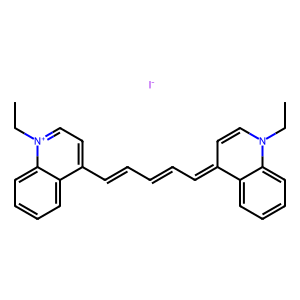

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Manually assigned SMILES for CAS: 18300-31-7
smiles = 'CCN1C=CC(=CC=CC=CC2=CC=[N+](C3=CC=CC=C23)CC)C4=CC=CC=C41.[I-]'

# Generate RDKit molecule
mol = Chem.MolFromSmiles(smiles)

# Draw and display the molecule
img = Draw.MolToImage(mol, size=(300, 300))
display(img)

In [8]:
input = '905-96-4'
cirpy.resolve( input, 'names')

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

## Plot the Absorption Spectra {-}

If you need to plot the absorption spectra we can use the same functions that were developed for the Kinetics experiment:

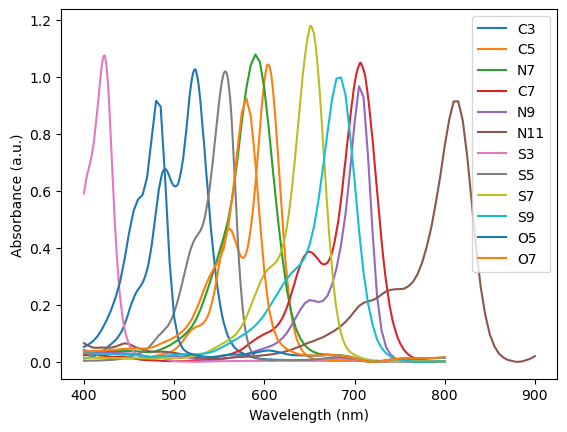

In [9]:
# Define all dyes with CAS-based filenames
dye0 = {'path': path, 'name': '977-96-8.csv', 'cas': '977-96-8', 'p': 3, 'hasO': 0, 'hasS': 0, 'label': 'C3'}
dye1 = {'path': path, 'name': '605-91-4.csv', 'cas': '605-91-4', 'p': 5, 'hasO': 0, 'hasS': 0, 'label': 'C5'}
dye2 = {'path': path, 'name': '4727-49-5.csv', 'cas': '4727-49-5', 'p': 7, 'hasO': 0, 'hasS': 0, 'label': 'N7'}
dye3 = {'path': path, 'name': '14187-31-6.csv', 'cas': '14187-31-6', 'p': 7, 'hasO': 0, 'hasS': 0, 'label': 'C7'}
dye4 = {'path': path, 'name': '4727-50-8.csv', 'cas': '4727-50-8', 'p': 9, 'hasO': 0, 'hasS': 0, 'label': 'N9'}
dye5 = {'path': path, 'name': '18300-31-7.csv', 'cas': '18300-31-7', 'p': 11, 'hasO': 0, 'hasS': 0, 'label': 'N11'}
dye6 = {'path': path, 'name': '2197-01-5.csv', 'cas': '2197-01-5', 'p': 3, 'hasO': 0, 'hasS': 1, 'label': 'S3'}
dye7 = {'path': path, 'name': '905-97-5.csv', 'cas': '905-97-5', 'p': 5, 'hasO': 0, 'hasS': 1, 'label': 'S5'}
dye8 = {'path': path, 'name': '514-73-8.csv', 'cas': '514-73-8', 'p': 7, 'hasO': 0, 'hasS': 1, 'label': 'S7'}
dye9 = {'path': path, 'name': '3071-70-3.csv', 'cas': '3071-70-3', 'p': 9, 'hasO': 0, 'hasS': 1, 'label': 'S9'}
dye10 = {'path': path, 'name': '905-96-4.csv', 'cas': '905-96-4', 'p': 5, 'hasO': 1, 'hasS': 0, 'label': 'O5'}
dye11 = {'path': path, 'name': '14806-50-9.csv', 'cas': '14806-50-9', 'p': 7, 'hasO': 1, 'hasS': 0, 'label': 'O7'}

# Collect all dyes into a list
dyes = [dye0, dye1, dye2, dye3, dye4, dye5, dye6, dye7, dye8, dye9, dye10, dye11]

# Plot the spectra
plot_file_list(dyes)

Note that the plotting command will take care of reading the files and saving the data of each file into the corresponding dictionary, with a key named 'data'. 

In [10]:
dye0['data'].head()

,wavelength,absorbance
0,800.002991,0.001599
1,798.996643,0.000000
2,797.989929,0.001383
3,796.982910,0.001416
4,796.010071,0.002160


In order to find the position of the peak, we can use the `argmax()` methods of the `DataFrame` object. This method finds the maximum value in a column and returns its index (NOTE: it does not return the maximum value but its row in the table). Knowing the row, we can look the value of the wavelength at that row to get the quantity we need.

In [11]:
dye0['lambda_exp'] = dye0['data'].loc[dye0['data']['absorbance'].idxmax(),'wavelength']
print(dye0['lambda_exp'])

522.9919434


We can automate this for all the dyes using a `for` loop:

In [12]:
for dye in dyes:
    dye['lambda_exp'] = dye['data']['wavelength'].iloc[dye['data']['absorbance'].argmax()]
    print(dye['label'],dye['lambda_exp'])

C3 522.9919434
C5 604.003479
N7 590.0182495
C7 707.012146
N9 705.0083008
N11 814.9932251
S3 423.0126953
S5 557.0178833
S7 650.9934082
S9 684.9921875
O5 479.9957886
O7 579.9848022


## Fit the Absorption Wavelengths {-}

In the following we will assume that you collected the values of the absorption wavelength from the instrument, instead of using the Python commands in the previous section. If, instead, you used the notebook to read the spectra and compute `lambda_exp`, you don't need to redefine a new set of dictionaries. 

Let's start by defining a dictionary for some of the molecules in our experiments. Apart from the absorptionn wavelength, these dictionaries will contain some basic information about your molecule (`hasO` and `hasS` refer to the presence of oxygen or sulfur atoms), but you can (should) add any additional characteristic of the molecule that you think may be involved with the absorption wavelength. If you add more features, make sure to add them to each dye and pay attention to avoid typos.

In [13]:

dye0 = { 'cas': '977-96-8', 'p': 3, 'hasO': 0, 'hasS': 0, 'lambda_exp': 522.9919434}
dye1 = { 'cas': '605-91-4', 'p': 5, 'hasO': 0, 'hasS': 0, 'lambda_exp': 604.003479}
dye2 = { 'cas': '4727-49-5', 'p': 7, 'hasO': 0, 'hasS': 0, 'lambda_exp': 590.0182495}
dye3 = { 'cas': '14187-31-6', 'p': 7, 'hasO': 0, 'hasS': 0, 'lambda_exp': 707.012146}
dye4 = { 'cas': '4727-50-8', 'p': 9, 'hasO': 0, 'hasS': 0, 'lambda_exp': 705.0083008}
dye5 = { 'cas': '18300-31-7', 'p': 11, 'hasO': 0, 'hasS': 0, 'lambda_exp': 814.9932251}
dye6 = { 'cas': '2197-01-5', 'p': 3, 'hasO': 0, 'hasS': 1, 'lambda_exp': 423.0126953}
dye7 = { 'cas': '905-97-5', 'p': 5, 'hasO': 0, 'hasS': 1, 'lambda_exp': 557.0178833}
dye8 = { 'cas': '514-73-8', 'p': 7, 'hasO': 0, 'hasS': 1, 'lambda_exp': 650.9934082}
dye9 = { 'cas': '3071-70-3', 'p': 9, 'hasO': 0, 'hasS': 1, 'lambda_exp': 762}
dye10 = { 'cas': '905-96-4', 'p': 5, 'hasO': 1, 'hasS': 0, 'lambda_exp': 479.9957886}
dye11 = { 'cas': '14806-50-9', 'p': 7, 'hasO': 1, 'hasS': 0, 'lambda_exp': 579.9848022}

As seen in previous notebooks, we can convert a list of dictionaries into a `Pandas.DataFrame`, which will be convenient for math operations and for producing tables.

In [51]:
dyes = [dye0, dye1, dye2, dye3, dye4, dye5, dye6, dye7, dye8, dye9, dye10, dye11]
dyes_data = pd.DataFrame(dyes)

In [52]:
print(dyes_data.to_markdown())

|    | cas        |   p |   hasO |   hasS |   lambda_exp |
|---:|:-----------|----:|-------:|-------:|-------------:|
|  0 | 977-96-8   |   3 |      0 |      0 |      522.992 |
|  1 | 605-91-4   |   5 |      0 |      0 |      604.003 |
|  2 | 4727-49-5  |   7 |      0 |      0 |      590.018 |
|  3 | 14187-31-6 |   7 |      0 |      0 |      707.012 |
|  4 | 4727-50-8  |   9 |      0 |      0 |      705.008 |
|  5 | 18300-31-7 |  11 |      0 |      0 |      814.993 |
|  6 | 2197-01-5  |   3 |      0 |      1 |      423.013 |
|  7 | 905-97-5   |   5 |      0 |      1 |      557.018 |
|  8 | 514-73-8   |   7 |      0 |      1 |      650.993 |
|  9 | 3071-70-3  |   9 |      0 |      1 |      762     |
| 10 | 905-96-4   |   5 |      1 |      0 |      479.996 |
| 11 | 14806-50-9 |   7 |      1 |      0 |      579.985 |


## Python Functions {-}

Here we introduce the Python way to define functions. We will use the following function to compute the relation between the absorption wavelength and the conjugation length of the dyes. 

In [16]:
def lambda_FE(p,alpha=0.):
    """
    Function to compute the absorption wavelenght (in nm)
    as a function of the number of carbon atoms in the conjugated chain
    and an optional parameter alpha that accounts for some wiggle room
    due to the aromatic rings
    """
    return 63.7*(p+3+alpha)**2/(p+4)

Given the function above, we can compute a new column of the dataframe with the predicted lambdas in one command

In [53]:
dyes_data['lambda_FE']=lambda_FE(dyes_data['p'])
dyes_data

,cas,p,hasO,hasS,lambda_exp,lambda_FE
0,977-96-8,3,0,0,522.991943,327.600000
1,605-91-4,5,0,0,604.003479,452.977778
2,4727-49-5,7,0,0,590.018250,579.090909
3,14187-31-6,7,0,0,707.012146,579.090909
4,4727-50-8,9,0,0,705.008301,705.600000
5,18300-31-7,11,0,0,814.993225,832.346667
6,2197-01-5,3,0,1,423.012695,327.600000
7,905-97-5,5,0,1,557.017883,452.977778
8,514-73-8,7,0,1,650.993408,579.090909
9,3071-70-3,9,0,1,762.000000,705.600000


We can visualize the results as usual

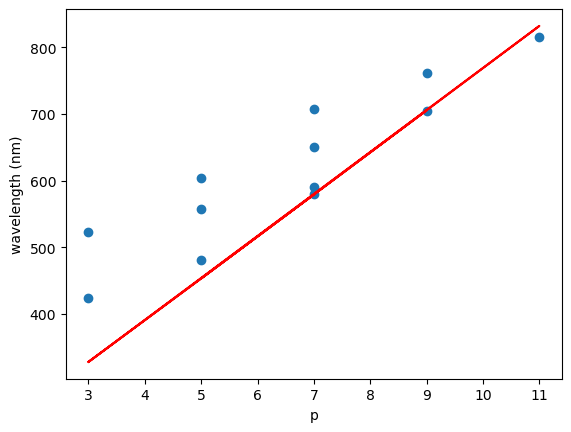

In [37]:
plt.scatter(dyes_data['p'],dyes_data['lambda_exp'])
plt.plot(dyes_data['p'],dyes_data['lambda_FE'],color='red')
plt.xlabel('p')
plt.ylabel('wavelength (nm)')
plt.show()

Given our experimental and predicted values of lambda, we can compute the sum of squares as follows:

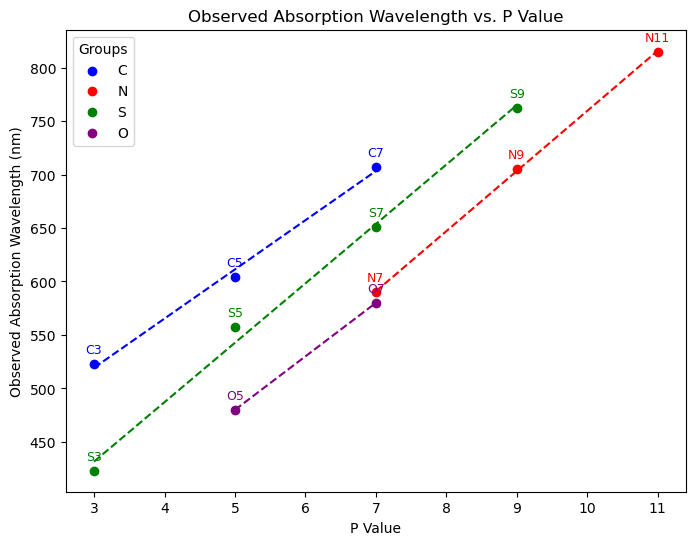

C-group: λ = 46.0051P + 381.3106
N-group: λ = 56.2437P + 197.1462
S-group: λ = 55.5469P + 264.9748
O-group: λ = 49.9945P + 230.0233


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the dyes data as a list of dictionaries
dyes = [
    {'cas': '977-96-8', 'p': 3, 'hasO': 0, 'hasS': 0, 'label': 'C3', 'group': 'C', 'lambda_exp': 522.991943},
    {'cas': '605-91-4', 'p': 5, 'hasO': 0, 'hasS': 0, 'label': 'C5', 'group': 'C', 'lambda_exp': 604.003479},
    {'cas': '4727-49-5', 'p': 7, 'hasO': 0, 'hasS': 0, 'label': 'N7', 'group': 'N', 'lambda_exp': 590.018250},
    {'cas': '14187-31-6', 'p': 7, 'hasO': 0, 'hasS': 0, 'label': 'C7', 'group': 'C', 'lambda_exp': 707.012146},
    {'cas': '4727-50-8', 'p': 9, 'hasO': 0, 'hasS': 0, 'label': 'N9', 'group': 'N', 'lambda_exp': 705.008301},
    {'cas': '18300-31-7', 'p': 11, 'hasO': 0, 'hasS': 0, 'label': 'N11', 'group': 'N', 'lambda_exp': 814.993225},
    {'cas': '2197-01-5', 'p': 3, 'hasO': 0, 'hasS': 1, 'label': 'S3', 'group': 'S', 'lambda_exp': 423.012695},
    {'cas': '905-97-5', 'p': 5, 'hasO': 0, 'hasS': 1, 'label': 'S5', 'group': 'S', 'lambda_exp': 557.017883},
    {'cas': '514-73-8', 'p': 7, 'hasO': 0, 'hasS': 1, 'label': 'S7', 'group': 'S', 'lambda_exp': 650.993408},
    {'cas': '3071-70-3', 'p': 9, 'hasO': 0, 'hasS': 1, 'label': 'S9', 'group': 'S', 'lambda_exp': 762.000000},
    {'cas': '905-96-4', 'p': 5, 'hasO': 1, 'hasS': 0, 'label': 'O5', 'group': 'O', 'lambda_exp': 479.995789},
    {'cas': '14806-50-9', 'p': 7, 'hasO': 1, 'hasS': 0, 'label': 'O7', 'group': 'O', 'lambda_exp': 579.984802}
]

# Convert list to pandas DataFrame
dyes_data = pd.DataFrame(dyes)

# Define colors for each group
colors = {'C': 'blue', 'N': 'red', 'S': 'green', 'O': 'purple'}

# Create the plot
plt.figure(figsize=(8, 6))

# Store trendline equations
trendline_equations = {}

for group, color in colors.items():
    group_data = dyes_data[dyes_data['group'] == group]

    if not group_data.empty:
        # Scatter plot for each group
        plt.scatter(group_data['p'], group_data['lambda_exp'], color=color, label=group)

        # Label points
        for i, row in group_data.iterrows():
            plt.text(row['p'], row['lambda_exp'] + 10, row['label'], fontsize=9, ha='center', color=color)

        # Linear fit
        m, b = np.polyfit(group_data['p'], group_data['lambda_exp'], 1)
        trendline_equations[group] = f"{group}-group: λ = {m:.4f}P + {b:.4f}"

        # Plot the trendline
        p_values = np.linspace(min(group_data['p']), max(group_data['p']), 100)
        plt.plot(p_values, m * p_values + b, color=color, linestyle='dashed')

# Formatting
plt.xlabel('P Value')
plt.ylabel('Observed Absorption Wavelength (nm)')
plt.title('Observed Absorption Wavelength vs. P Value')
plt.legend(title="Groups", loc='upper left')

# Display the plot
plt.show()

# Print trendline equations
for eq in trendline_equations.values():
    print(eq)

In [39]:
TSS=np.sum((dyes_data['lambda_exp']-dyes_data['lambda_exp'].mean())**2)
print("The total sum of squares is {:10.4f} ".format(TSS))

The total sum of squares is 148329.1170 


In [54]:
RSS=np.sum((dyes_data['lambda_exp']-dyes_data['lambda_FE'])**2)
print("The residual sum of squares is {:10.4f} ".format(RSS))

The residual sum of squares is 106781.1430 


In [55]:
R2=1-(RSS/TSS)
print("The coefficient of determination R2 for the particle in a box model is {:5.4f} ".format(R2))

The coefficient of determination R2 for the particle in a box model is 0.2801 


## Finding the Value of Alpha {-}

There are a few different ways we can find the value of $\alpha$ that best reproduces the experimental absorption wavelengths. 

* Given the experimental values of $\lambda$, we could compute the optimal alpha for each individual molecule and than take the average over all the molecules.
* More accurately, we could generate a range of values of $\alpha$ and for each of them compute the $RSS$. The best fit is the one for which the $RSS$ is the lowest. 
* We could linearize the dependence on $p$ in the formula above (i.e., by taking the limit of the formula as $p$ becomes large) and use linear regression to fit the experimental data. From the slope and/or intercept we could estimate $\alpha$. 

Let's try the first approach (but if you want to learn python, try one of the other two as well).

From the formula of $\lambda$ as a function of $\alpha$, we can derive a formula that, given $\lambda$, calculates $\alpha$:

$$\lambda = 63.7\frac{(p+3+\alpha)^2}{(p+4)} \rightarrow \alpha = \sqrt{\frac{\lambda(p+4)}{63.7}}-p-3$$

In [56]:
dyes_data['alpha']=np.sqrt(dyes_data['lambda_exp']*(dyes_data['p']+4)/63.7)-dyes_data['p']-3

In [57]:
dyes_data.head()  # Prints all rows


,cas,p,hasO,hasS,lambda_exp,lambda_FE,alpha
0,977-96-8,3,0,0,522.991943,327.600000,1.581005
1,605-91-4,5,0,0,604.003479,452.977778,1.237857
2,4727-49-5,7,0,0,590.018250,579.090909,0.093908
3,14187-31-6,7,0,0,707.012146,579.090909,1.049435
4,4727-50-8,9,0,0,705.008301,705.600000,-0.005033


We can now approximate the optimal value of $\alpha$ to be the average over the molecules we have, and recompute the model's prediction

In [58]:
alpha_average = dyes_data['alpha'].mean()
dyes_data['lambda_alpha']=lambda_FE(dyes_data['p'],alpha_average)

and visualize the results (NOTE: make sure to add titles and axis labels to your plots)

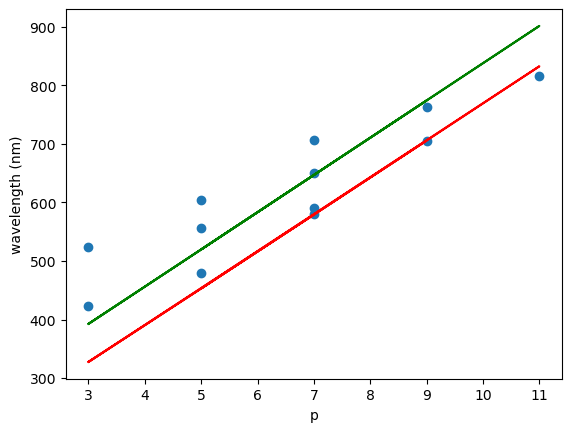

In [59]:
plt.scatter(dyes_data['p'],dyes_data['lambda_exp'],label='experiment')
plt.plot(dyes_data['p'],dyes_data['lambda_FE'],color='red',label='particle in a box')
plt.plot(dyes_data['p'],dyes_data['lambda_alpha'],color='green',label='particle in a box + alpha')
plt.xlabel('p')
plt.ylabel('wavelength (nm)')
plt.show()

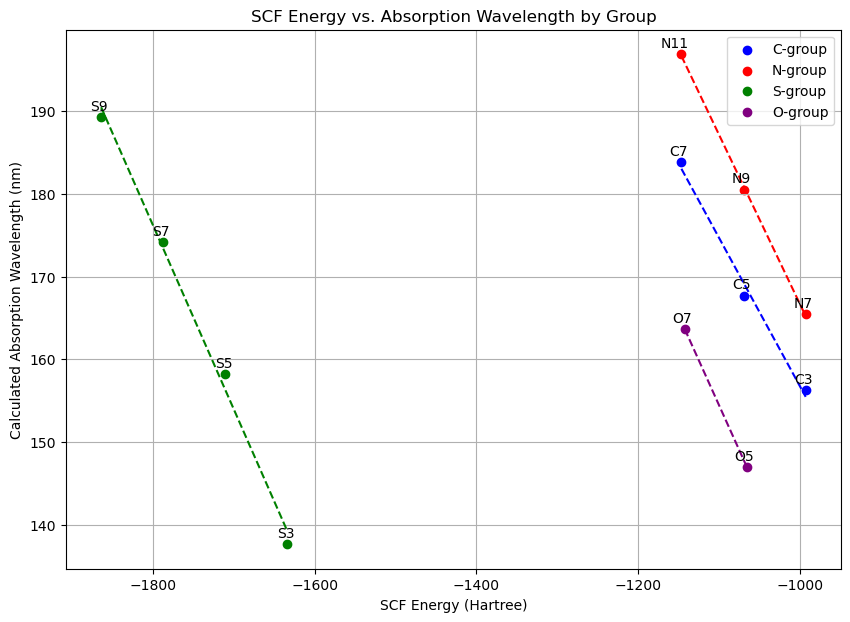

C-group: λ = -0.1794 * SCF Energy + -22.6280 (R² = 0.9905)
N-group: λ = -0.2046 * SCF Energy + -37.8607 (R² = 0.9994)
S-group: λ = -0.2225 * SCF Energy + -224.4388 (R² = 0.9945)
O-group: λ = -0.2170 * SCF Energy + -84.2596 (R² = 1.0000)


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

# Data (SCF energies and calculated absorption wavelengths)
dyes_data = pd.DataFrame({
    "label": ["C3", "C5", "N7", "C7", "N9", "N11", "S3", "S5", "S7", "S9", "O5", "O7"],
    "SCF_energy": [-992.67, -1069.55, -992.68, -1146.41, -1069.56, -1146.41, -1633.87, -1710.75, -1787.61, -1864.46, -1065.44, -1142.30],
    "calc_abs_wavelength": [156.23, 167.68, 165.44, 183.81, 180.51, 196.89, 137.62, 158.18, 174.19, 189.30, 146.96, 163.64]
})

# Define groups by prefixes
group_colors = {"C": "blue", "N": "red", "S": "green", "O": "purple"}
group_labels = {"C": "C-group", "N": "N-group", "S": "S-group", "O": "O-group"}

# Plot setup
plt.figure(figsize=(10, 7))
plt.xlabel("SCF Energy (Hartree)")
plt.ylabel("Calculated Absorption Wavelength (nm)")
plt.title("SCF Energy vs. Absorption Wavelength by Group")

# Store line fits
line_fits = {}

# Iterate through each group
for prefix, color in group_colors.items():
    group_data = dyes_data[dyes_data["label"].str.startswith(prefix)]

    if not group_data.empty:
        # Scatter plot for the group
        plt.scatter(group_data["SCF_energy"], group_data["calc_abs_wavelength"], color=color, label=group_labels[prefix])

        # Linear regression (line of best fit)
        slope, intercept, r_value, _, _ = linregress(group_data["SCF_energy"], group_data["calc_abs_wavelength"])
        line_fits[prefix] = (slope, intercept, r_value**2)

        # Generate line of best fit
        x_vals = np.linspace(min(group_data["SCF_energy"]), max(group_data["SCF_energy"]), 100)
        y_vals = slope * x_vals + intercept
        plt.plot(x_vals, y_vals, linestyle="dashed", color=color)

        # Annotate points
        for i, row in group_data.iterrows():
            plt.annotate(row["label"], (row["SCF_energy"], row["calc_abs_wavelength"]), textcoords="offset points", xytext=(5, 5), ha='right', fontsize=10)

# Display legend
plt.legend()
plt.grid(True)
plt.show()

# Print line fits
for prefix, (slope, intercept, r2) in line_fits.items():
    print(f"{group_labels[prefix]}: λ = {slope:.4f} * SCF Energy + {intercept:.4f} (R² = {r2:.4f})")

C-group: λ = 6.8935P + 134.7735
N-group: λ = 7.8605P + 110.2018
S-group: λ = 8.5524P + 113.5061
O-group: λ = 8.3410P + 105.2550


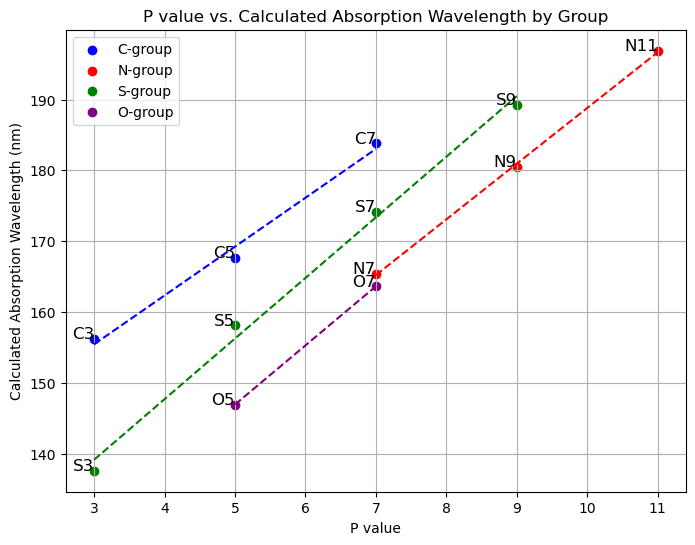

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

# Sample data
dyes_data = pd.DataFrame({
    'p': [3, 5, 7, 7, 9, 11, 3, 5, 7, 9, 5, 7],  # P values
    'lambda_calc': [156.233, 167.683, 165.444, 183.807, 180.509, 196.886, 137.616, 158.181, 174.189, 189.296, 146.960, 163.642],  # Calculated Absorption Wavelengths
    'label': ['C3', 'C5', 'N7', 'C7', 'N9', 'N11', 'S3', 'S5', 'S7', 'S9', 'O5', 'O7'],  # Labels for points
    'group': ['C', 'C', 'N', 'C', 'N', 'N', 'S', 'S', 'S', 'S', 'O', 'O']  # Grouping by composition
})

# Define unique colors for each group
colors = {'C': 'blue', 'N': 'red', 'S': 'green', 'O': 'purple'}

# Plot scatter points
plt.figure(figsize=(8,6))
for group in colors.keys():
    subset = dyes_data[dyes_data['group'] == group]
    plt.scatter(subset['p'], subset['lambda_calc'], color=colors[group], label=f'{group}-group')

    # Linear regression for each group
    X = subset['p'].values.reshape(-1, 1)
    y = subset['lambda_calc'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # Plot best-fit line
    plt.plot(subset['p'], y_pred, color=colors[group], linestyle='dashed')

    # Print equation
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"{group}-group: λ = {slope:.4f}P + {intercept:.4f}")

# Add labels to points
for i, row in dyes_data.iterrows():
    plt.text(row['p'], row['lambda_calc'], row['label'], fontsize=12, ha='right')

# Final plot settings
plt.xlabel('P value')
plt.ylabel('Calculated Absorption Wavelength (nm)')
plt.title('P value vs. Calculated Absorption Wavelength by Group')
plt.legend()
plt.grid(True)
plt.show()

## Quantum Mechanical Calculations {-}

Most chemistry applications of quantum mechanics (a.k.a. quantum chemistry) relies on a powerful commercial software called Gaussian. This code was first developed by a forefather of quantum chemistry and Nobel prize winner John Pople. However, Gaussian is a Fortran 77 code that requires an expensive license to run. For our applications we can achieve the same results using Python-based codes, at the expense of some computing time. In the following we will be using [PySCF](https://pyscf.org/index.html) for our quantum chemistry calculations, so we will need to install it on our Colab instance.

In [111]:
!pip install pyscf
!pip install pyscf[geomopt]
from pyscf import gto, scf, lo, tools
from pyscf.geomopt.berny_solver import optimize
#
from scipy.constants import physical_constants # we will need these for units conversion

zsh:1: no matches found: pyscf[geomopt]


Let's first go through the main steps of a QC calculation on a simple small molecule, i.e. methane. Before we run any simulation, we need to get some initial guess for the positions of the atoms of our molecule. Luckly we can use `cirpy` to convert our molecule into a `xyz` format, that contains the number of atoms, a comment line, followed by the element and Cartesian coordinates of all the atoms in the molecule. 

In [112]:
print(cirpy.resolve('methane','xyz'))

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

For our calculation we only need the atoms information, so we will use some `str`+`list` methods to remove the first two lines from the `xyz` format. 

In [225]:
xyz = ''.join(string+'\n' for string in cirpy.resolve('methane','xyz').split('\n')[2:])
print(xyz)

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

We can now create a `Mole` object in PySCF and setup the QC method to use. Part of the accuracy of your calculation will depend on the basis set adopted. The larger the basis set is, the more expensive and (hopefully) more accurate the calculation will be. The available basis sets are listed [here](https://pyscf.org/_modules/pyscf/gto/basis.html). Common choices for small organic molecules go include: `631g`, `631+g*`, `6311g`, and `6311++g**`.  

In [144]:
mol = gto.M(atom=xyz, basis='631g')

NameError: name 'xyz' is not defined

There are a few different methods to choose from: Hartree-Fock ([HF](https://pyscf.org/user/scf.html), cheaper, but not very accurate) and Kohn-Sham Density Functional Theory (DFT, or [KS](https://pyscf.org/user/dft.html)) are the most popular options for organic molecules. There are many different flavors of DFT, each with its own acronym. A list of options is available [here](https://github.com/pyscf/pyscf/blob/master/pyscf/dft/libxc.py), searching for XC_ALIAS. 

In [145]:
mf = mol.KS()
mf.xc = 'b3lyp' # B3LYP functional, a pretty common choice for organic molecules

NameError: name 'mol' is not defined

The first step in a QC calculation is to optimize (or relax) the positions of the atoms (remember we started from a guess that may be wrong or not in agreement with the QM level of theory we are using). 

In [146]:
mol_eq = optimize(mf, maxsteps=100)
print(mol_eq.tostring())

NameError: name 'mf' is not defined

Now that we have a more appropriate geometry of our molecule, we can compute the ground state energy and the orbital energies, maybe using a more expensive level of theory.

In [147]:
mol_eq.basis = '6311++g**'
mf = mol_eq.KS()
mf.xc = 'b3lyp'
mf.kernel()

NameError: name 'mol_eq' is not defined

Once the calculation is finished, the results are all stored inside our object. For example, we can access the orbital energies and occupations.

In [148]:
print(mf.mo_occ)
print(mf.mo_energy)

NameError: name 'mf' is not defined

Now we can try to apply the same process to our conjugated dyes. NOTE: we need to only select the organic part of the dye, not the iodine atom. To do this, we may want to generate the SMILES of the molecule and manually remove the `I.` part.

Contrary to the methane example, the dye is positively charged, we need to specify this when we setup the molecule. 

In [233]:
smile = 'CCN1C(C=Cc2ccccc12)=Cc3ccc4ccccc4[n+]3CC'
xyz = ''.join(string+'\n' for string in cirpy.resolve(smile,'xyz').split('\n')[2:])
print(xyz)

C    2.8885    3.1206    0.1302
C    2.5435    2.0521   -0.9091
N    2.2916    0.7769   -0.2334
C    1.0420    0.4764    0.1661
C    0.7455   -0.7402    0.8221
C    1.7325   -1.6389    1.0633
C    3.0901   -1.3122    0.6292
C    4.1524   -2.1957    0.8472
C    5.4084   -1.8596    0.4285
C    5.6423   -0.6489   -0.2115
C    4.6195    0.2356   -0.4380
C    3.3229   -0.0836   -0.0262
C    0.0120    1.3899   -0.0732
C   -1.3094    1.0470    0.2251
C   -1.9900    1.7492    1.2458
C   -3.2731    1.4302    1.5492
C   -3.9172    0.3540    0.7976
C   -5.2381   -0.0235    1.0607
C   -5.8096   -1.0329    0.3395
C   -5.0927   -1.6891   -0.6533
C   -3.7966   -1.3395   -0.9321
C   -3.1855   -0.3106   -0.2106
N   -1.9041    0.0601   -0.4703
C   -1.1546   -0.6311   -1.5223
C   -1.2840    0.1449   -2.8346
H    3.0759    4.0694   -0.3725
H    2.0554    3.2353    0.8237
H    3.7799    2.8184    0.6800
H    1.6522    2.3543   -1.4588
H    3.3766    1.9374   -1.6026
H   -0.2668   -0.9539    1.1316
H    1.5

In [237]:
dye = gto.M(atom=xyz, basis='6-31+G*', charge=1, spin=0)

The dyes in our experiments are large molecules and we may not be able to perform QC calculations fast enough for the lab, so we will use cheaper levels of theory (`HF` and `631g`) and no geometry optimization.  

In [ ]:
mf = dye.KS()
mf.xc = 'b3lyp'  # Use B3LYP functional (better for organic molecules)
mf.kernel()

# Run TD-DFT for excited states
from pyscf.tdscf import TDDFT
td = TDDFT(mf)
td.kernel()


WARN: Singularity detected in overlap matrix (condition number = 1.55e+08). SCF may be inaccurate and hard to converge.



/opt/anaconda3/lib/python3.12/site-packages/pyscf/dft/libxc.py:512: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = -999.578824667576


Once the calculation has finished, we can extract HOMO and LUMO energies and convert the gap into our estimated absorption wavelength.

In [236]:
lumo = mf.mo_energy[np.where(mf.mo_occ==0)[0][0]] # orbital energies in atomic units (Hartree)
homo = mf.mo_energy[np.where(mf.mo_occ==0)[0][0]-1] # orbital energies in atomic units (Hartree)
Eg = (lumo-homo)*dict(physical_constants)['Hartree energy'][0]
wavelength = dict(physical_constants)['Planck constant'][0] * dict(physical_constants)['speed of light in vacuum'][0] / Eg * 1e9
print(f"The absorption wavelength from the Hartree-Fock/6-31G HOMO-LUMO gap is {wavelength} nm")

The absorption wavelength from the Hartree-Fock/6-31G HOMO-LUMO gap is 156.2331133939235 nm


## Huckel Model for Conjugated Molecules {-}

While for the Full Report you will only worry about modeling your experiments with a Free Electron (Particle in a Box) kind of model, here we will try to understand how we can use a slightly more advanced quantum mechanical model to predict absorption wavelengths. The Huckel model is a semi-empirical quantum mechanical model that has been developed to describe conjugted systems. While the model relies on some adjustable parameters and involves several possibly strong assumptions, it allows to reproduce some key properties of conjugated and aromatic molecules.

You can learn more on the theory and assumptions of the model in the lectures and in the following online resources: 
* MIT Physical Chemistry on [The Huckel Molecular Orbital Theory](https://dspace.mit.edu/bitstream/handle/1721.1/120336/5-61-fall-2013/contents/lecture-notes/MIT5_61F13_Lecture27-28.pdf)
* P-Chem Lab from Duke University [The Huckel Approximation](https://chem.libretexts.org/Courses/Duke_University/CHEM310L_-_Physical_Chemistry_I_Lab_Manual/04%3A_Absorption_Spectrum_of_Conjugated_Dyes/4.07%3A_Appendix_B_-_The_Huckel_Approximation)
* Columbia Notes on [The Huckel Approximation](http://www.columbia.edu/itc/chemistry/chem-c2407_archive/recitations/huckel.pdf)


The key component of the Huckel model is the fact that the molecular orbitals are univoquely determined by the topology of the conjugated network. The model assumes that we only consider the $p_z$ orbitals of each conjugated atom and we build molecular orbitals from them. As a further approximation, only atomic orbitals that are in connected atoms are allowed to 'interact'. Eventually, we assume that all atoms and bonds are equivalent, so that the relative components of the molecular Hamiltonian are identical. The Hamiltonian of the system can thus be represented as a matrix, where diagonal cells $H_{ii}$ have identical values, while off-diagonal elements $H_{ij}$ are different from zero only if there is a bond between atom $i$ and atom $j$. For carbon based molecules, the model only relies on two parameters $\alpha$ and $\beta$. However, the difference in energy between the electronic states only depends on the latter parameter, which is usually estimated to be $\beta\approx-70.4\; kcal/mol$.

In [194]:
n_conjugated = 2
alpha = -2
beta = -1
topology = np.zeros((n_conjugated,n_conjugated))
diagonal = np.ones(n_conjugated)*alpha
offdiagonal = np.ones(n_conjugated-1)*beta
topology = topology + np.diag(diagonal,0) + np.diag(offdiagonal,1) + np.diag(offdiagonal,-1)
print(topology)

[[-2. -1.]
 [-1. -2.]]


Molecular orbitals are given by the linear combinations of atomic orbitals that make the Hamiltonian diagonal and minimize the energy of the system. Diagonalization of the Hamiltonian is a linear algebra problem (eigenvalue problem). We can use numpy to compute eigenvalues (a.k.a. orbital energies) and eigenvectors (a.k.a. the values of the coefficients that enter the definition of the molecular orbitals).

In [195]:
eigenvalues,eigenvectors=np.linalg.eig(topology)
print(eigenvalues)

[-1. -3.]


For the more complicated case of butane we can build the Huckel Hamiltonian as follows:

In [196]:
n_conjugated = 4
alpha = -2
beta = -1
topology = np.zeros((n_conjugated,n_conjugated))
diagonal = np.ones(n_conjugated)*alpha
offdiagonal = np.ones(n_conjugated-1)*beta
topology = topology + np.diag(diagonal,0) + np.diag(offdiagonal,1) + np.diag(offdiagonal,-1)
print(topology)

[[-2. -1.  0.  0.]
 [-1. -2. -1.  0.]
 [ 0. -1. -2. -1.]
 [ 0.  0. -1. -2.]]


which corresponds to the following orbital energies and coefficients

In [197]:
eigenvalues,eigenvectors=np.linalg.eig(topology)
print(eigenvalues)

[-3.61803399 -2.61803399 -0.38196601 -1.38196601]


You can note that the energies above are all different from the starting energy of the $p_z$ orbitals, which was arbitrary set to $-200\;kcal/mol$. For this kind of Hamiltonians, the eigenvalues can be expressed with an analytical formula $E_j=\alpha+2\beta\cos\left(\frac{\pi}{N+1}J\right)$, with $J=1,2,\dots ,N$. For longer conjugated chains, assuming that we have one electron for each atomic orbital (so number of electrons is $N$ and only the first $N/2$ orbitals are filled), we can estimate the energy difference associated with the absorption maximum as $\Delta E=-4\beta\sin\left(\frac{\pi}{2}\frac{1}{N+1}\right)$. When accounting for the different units, this energy corresponds to a wavelenght of $\lambda^{HMO}=-\frac{28585\;(kcal/mol)}{2\pi\beta\;(kcal/mol)}N$. As for the free electron model, the Huckel Molecular Orbital approach predicts an absorption wavelength that is linear in the number of conjugated centers. The tunable parameter in this case is the $\beta$ constant. 

However, the Huckel model can be automatically extended to account for the aromatic rings and it can, with additional parameters, be extended to include heteroatoms. For example, it is worth looking at the results of the Huckel model for a benzene molecule.

In [198]:
n_conjugated = 6
alpha = -2.
beta = -1.
topology = np.zeros((n_conjugated,n_conjugated))
diagonal = np.ones(n_conjugated)*alpha
offdiagonal = np.ones(n_conjugated-1)*beta
topology[0,n_conjugated-1]=beta
topology[n_conjugated-1,0]=beta
topology = topology + np.diag(diagonal,0) + np.diag(offdiagonal,1) + np.diag(offdiagonal,-1)
print(topology)

[[-2. -1.  0.  0.  0. -1.]
 [-1. -2. -1.  0.  0.  0.]
 [ 0. -1. -2. -1.  0.  0.]
 [ 0.  0. -1. -2. -1.  0.]
 [ 0.  0.  0. -1. -2. -1.]
 [-1.  0.  0.  0. -1. -2.]]


Note that in the following we re-order the results of the eigenvalue problem so that we can see the states in order of their energies (from the largest less stable to the smallest more stable)

In [199]:
eigenvalues,eigenvectors=np.linalg.eig(topology)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

We can use matplotlib to visualize the coefficients in terms of their signs and magnitudes as follows.

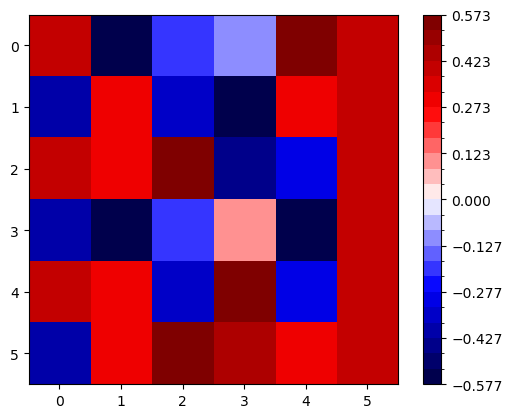

In [200]:
from matplotlib.colors import BoundaryNorm
bounds = np.arange(np.min(eigenvectors),np.max(eigenvectors),.05)
cmap = plt.get_cmap('seismic')
idx=np.searchsorted(bounds,0)
bounds=np.insert(bounds,idx,0)
norm = BoundaryNorm(bounds, cmap.N)
plt.imshow(eigenvectors,interpolation='none',norm=norm,cmap=cmap)
plt.colorbar()
plt.show()


If you have time, you could try to build a topology matrix for a few of the molecules involved in the experiments and compare the HOMO-LUMO energy difference with the formula reported above for a linear conjugated chain.